In [1]:
!pip install transformers torchvision scikit-learn pandas openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image

from transformers import BertTokenizer, BertModel

import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import random
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

2025-05-20 04:17:43.639098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747714663.817374      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747714663.870448      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_excel('/kaggle/input/twitter-dataset-for-sentiment-analysis/LabeledText.xlsx', sheet_name='final label')

In [4]:
print(df.columns)

Index(['File Name', 'Caption', 'LABEL'], dtype='object')


In [5]:
df['File Name'] = df['File Name'].apply(lambda x: x.replace('.txt', '.jpg'))

In [6]:
df.rename(columns={'Caption': 'text', 'LABEL': 'label'}, inplace=True)

In [7]:
df['label'] = df['label'].str.strip().str.lower()

In [8]:
def replace_url(text):
    return re.sub(r'https?:\/\/\S+|www\.\S+', 'URL', text)

def remove_html(text):
    return re.sub('<.*?>', '', text)

def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

def replace_num(text):
    return re.sub(r'\d+', 'NUMBER', text)

def replace_heart(text):
    return re.sub('<3', 'HEART', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

def remove_punctuations(text):
    return ''.join([word for word in text if word not in string.punctuation])

def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

def replace_hashtags(text):
    return re.sub(r'#(\w+)', r'\1', text)


def lemmatization(text):
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = replace_url(text)
    text = replace_hashtags(text)    
    text = replace_mentions(text)    
    text = remove_punctuations(text)
    text = remove_alphanumeric(text)
    text = replace_heart(text)
    text = remove_stopwords(text)
    text = remove_html(text)
    text = lemmatization(text)
    text = replace_num(text)
    return text


In [10]:
print(clean_text("@ArrivaTW absolute disgrace #gym <3"))


user absolute disgrace gym


In [11]:
df['text_clean'] = df['text'].apply(clean_text)

In [12]:
df[['text', 'text_clean', 'label']].head()

,text,text_clean,label
0,How I feel today #legday #jelly #aching #gym,feel today legday jelly ache gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,user absolute disgrace two carriages bangor ha...,negative
2,This is my Valentine's from 1 of my nephews. I...,valentines nephews elate sometimes little thin...,positive
3,betterfeelingfilms: RT via Instagram: First da...,betterfeelingfilms rt via instagram first day ...,neutral
4,Zoe's first love #Rattled @JohnnyHarper15,zoes first love rattle user,positive


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])   
])


In [15]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'negative': 0, 'neutral': 1, 'positive': 2}


In [16]:
label_folder_map = {
    "negative": "Negative",
    "neutral": "Neutral",
    "positive": "positive"  
}

def get_image_path(row):
    label_folder = label_folder_map[row["label"].lower()]
    return f"/kaggle/input/twitter-dataset-for-sentiment-analysis/Images/Images/{label_folder}/{row['File Name']}"

df['image_path'] = df.apply(get_image_path, axis=1)


In [17]:
missing_images = df[~df['image_path'].apply(os.path.exists)]
print(f"Missing {len(missing_images)} image(s):")
print(missing_images[['File Name', 'label', 'image_path']])

Missing 0 image(s):
Empty DataFrame
Columns: [File Name, label, image_path]
Index: []


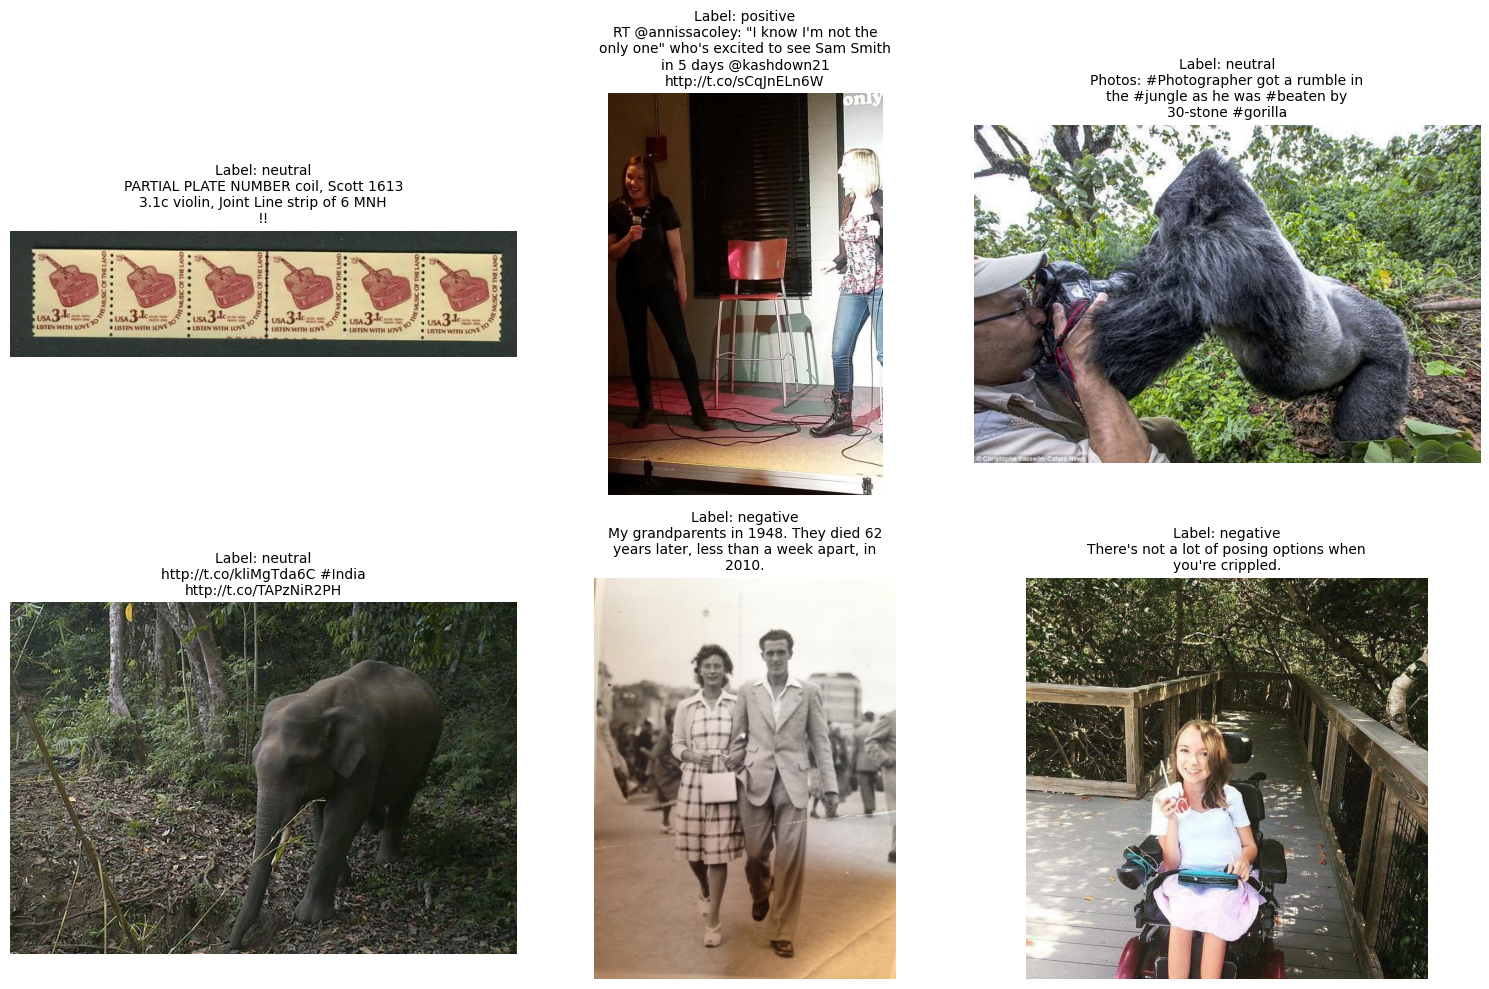

In [18]:
import textwrap

NUM_SAMPLES = 6

sample_df = df.sample(n=NUM_SAMPLES).reset_index(drop=True)

plt.figure(figsize=(15, 10))

for i in range(NUM_SAMPLES):
    img_path = sample_df.loc[i, 'image_path']
    try:
        image = Image.open(img_path)
        label = sample_df.loc[i, 'label']
        text = sample_df.loc[i, 'text']

        
        wrapped_text = "\n".join(textwrap.wrap(text, width=40))

        plt.subplot(2, 3, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Label: {label}\n{wrapped_text}", fontsize=10)

    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()

In [19]:
class MultimodalSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['text_clean']
        image_path = row['image_path']
        label = row['label_encoded']

        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [20]:
df['label_encoded'] = LabelEncoder().fit_transform(df['label'])


In [21]:
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)


In [22]:

train_val_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df['label_encoded'], random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df['label_encoded'], random_state=42
)

train_dataset = MultimodalSentimentDataset(train_df, tokenizer, image_transforms)
val_dataset = MultimodalSentimentDataset(val_df, tokenizer, image_transforms)
test_dataset = MultimodalSentimentDataset(test_df, tokenizer, image_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
class MVSA_Dataset(Dataset):
    def __init__(self, dataframe, image_root, tokenizer, transform, max_length=128):
        self.df = dataframe
        self.image_root = image_root
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

        
        self.df['image_path'] = self.df['image_path'].apply(lambda x: os.path.join(image_root, x))
        self.df = self.df[self.df['image_path'].apply(os.path.exists)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        
        text = str(row['text'])
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=self.max_length)
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        
        image = Image.open(row['image_path']).convert('RGB')
        image = self.transform(image)

        
        label = row['label']  
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [24]:
from torchvision.models import resnet50, ResNet50_Weights

class MultimodalBERTResNetModel(nn.Module):
    def __init__(self, num_classes=3, text_model_name='bert-base-uncased'):
        super(MultimodalBERTResNetModel, self).__init__()
        
        
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.text_dropout = nn.Dropout(0.3)
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)

        
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False  
        resnet.fc = nn.Identity()  
        self.image_model = resnet
        self.image_fc = nn.Linear(2048, 256)

        
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 128),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask, images):
        
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = text_output.pooler_output  
        text_features = self.text_fc(self.text_dropout(pooled_output))

        
        image_features = self.image_fc(self.image_model(images))

        
        combined = torch.cat((text_features, image_features), dim=1)

        
        output = self.fusion_fc(combined)
        return output

In [25]:
from torchvision import models
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalBERTResNetModel().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s] 


In [26]:
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)


In [27]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
        loss = criterion(outputs, labels)
        acc = calculate_accuracy(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    return total_loss / len(data_loader), total_acc / len(data_loader)

def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)

            total_loss += loss.item()
            total_acc += acc

    return total_loss / len(data_loader), total_acc / len(data_loader)

In [28]:
EPOCHS = 10

best_val_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_multimodal_model.pth")
        print(" Model saved.")

Epoch 1/10
Train Loss: 0.9633, Train Acc: 0.5136
Val   Loss: 0.7736, Val   Acc: 0.7015
 Model saved.
Epoch 2/10
Train Loss: 0.6560, Train Acc: 0.7392
Val   Loss: 0.6741, Val   Acc: 0.7333
 Model saved.
Epoch 3/10
Train Loss: 0.4728, Train Acc: 0.8267
Val   Loss: 0.6072, Val   Acc: 0.7669
 Model saved.
Epoch 4/10
Train Loss: 0.3212, Train Acc: 0.8895
Val   Loss: 0.6607, Val   Acc: 0.7606
Epoch 5/10
Train Loss: 0.2231, Train Acc: 0.9307
Val   Loss: 0.7034, Val   Acc: 0.7665
Epoch 6/10
Train Loss: 0.1703, Train Acc: 0.9463
Val   Loss: 0.8316, Val   Acc: 0.7370
Epoch 7/10
Train Loss: 0.1191, Train Acc: 0.9651
Val   Loss: 0.8149, Val   Acc: 0.7759
 Model saved.
Epoch 8/10
Train Loss: 0.0916, Train Acc: 0.9741
Val   Loss: 0.8394, Val   Acc: 0.7665
Epoch 9/10
Train Loss: 0.0755, Train Acc: 0.9784
Val   Loss: 0.9625, Val   Acc: 0.7574
Epoch 10/10
Train Loss: 0.0548, Train Acc: 0.9852
Val   Loss: 1.0209, Val   Acc: 0.7790
 Model saved.


In [29]:
# Load the best saved model
model.load_state_dict(torch.load("best_multimodal_model.pth"))
model.to(device)

# Print number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Total Parameters: 133777731
Trainable Parameters: 110269699


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, data_loader, device, name=""):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n--- {name} Evaluation ---")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
    return all_labels, all_preds

# Evaluate
val_labels, val_preds = evaluate_model(model, val_loader, device, "Validation")
test_labels, test_preds = evaluate_model(model, test_loader, device, "Test")



--- Validation Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77       262
           1       0.70      0.77      0.73       319
           2       0.88      0.80      0.84       296

    accuracy                           0.78       877
   macro avg       0.79      0.78      0.78       877
weighted avg       0.78      0.78      0.78       877

Confusion Matrix:
 [[198  58   6]
 [ 45 247  27]
 [  9  49 238]]

--- Test Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69       145
           1       0.69      0.76      0.72       177
           2       0.93      0.82      0.87       165

    accuracy                           0.76       487
   macro avg       0.77      0.76      0.76       487
weighted avg       0.77      0.76      0.76       487

Confusion Matrix:
 [[101  42   2]
 [ 35 134   8]
 [ 10  19 136]]


In [31]:
torch.save(model.state_dict(), '/kaggle/working/model_state_dict.pth')


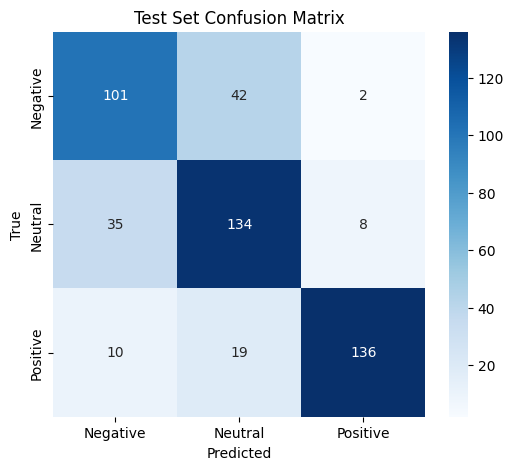

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_conf_matrix(true_labels, preds, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Example usage:
class_names = ['Negative', 'Neutral', 'Positive']
plot_conf_matrix(test_labels, test_preds, class_names, title="Test Set Confusion Matrix")


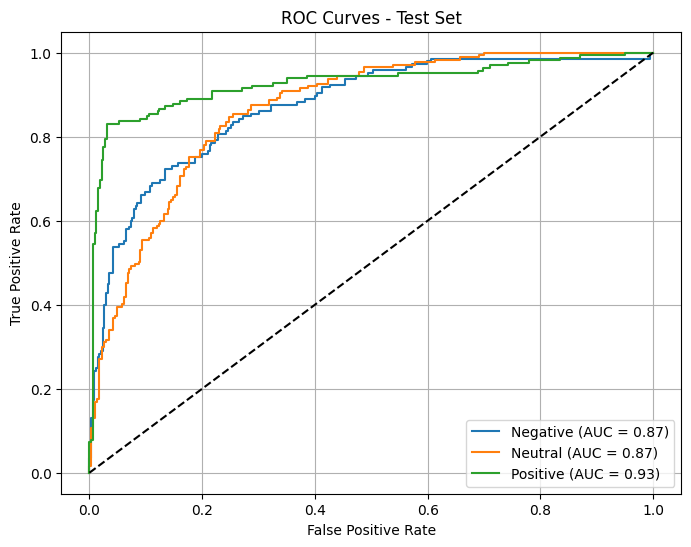

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

def plot_roc_curve(model, data_loader, device, num_classes):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
            probs = torch.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Binarize labels
    y_true = label_binarize(all_labels, classes=list(range(num_classes)))
    y_score = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Test Set')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_roc_curve(model, test_loader, device, num_classes=3)
